!Training the Q-learning agent!
!Generating data for neural network training!
Data saved to 'q_learning_data.csv'.

 Analyzing extreme configuration 1: {'taxi_row': 0, 'taxi_col': 0, 'passenger_index': 3, 'destination_index': 0}

Testing configuration: {'taxi_row': 0, 'taxi_col': 0, 'passenger_index': 3, 'destination_index': 0}
  Average Reward: 8.31
  Average Steps: 12.69
  Average Penalties: 0.00

 Analyzing extreme configuration 2: {'taxi_row': 4, 'taxi_col': 4, 'passenger_index': 0, 'destination_index': 3}

Testing configuration: {'taxi_row': 4, 'taxi_col': 4, 'passenger_index': 0, 'destination_index': 3}
  Average Reward: 8.03
  Average Steps: 12.97
  Average Penalties: 0.00

 Starting simulation for a random configuration :
  Taxi Initial Location: (row=2, col=4)
  Passenger Location: 0
  Destination: 3
Step 1: Action=3, Reward=-1
Step 2: Action=3, Reward=-1
Step 3: Action=3, Reward=-1
Step 4: Action=1, Reward=-1
Step 5: Action=1, Reward=-1
Step 6: Action=3, Reward=-1
Step 7: Act

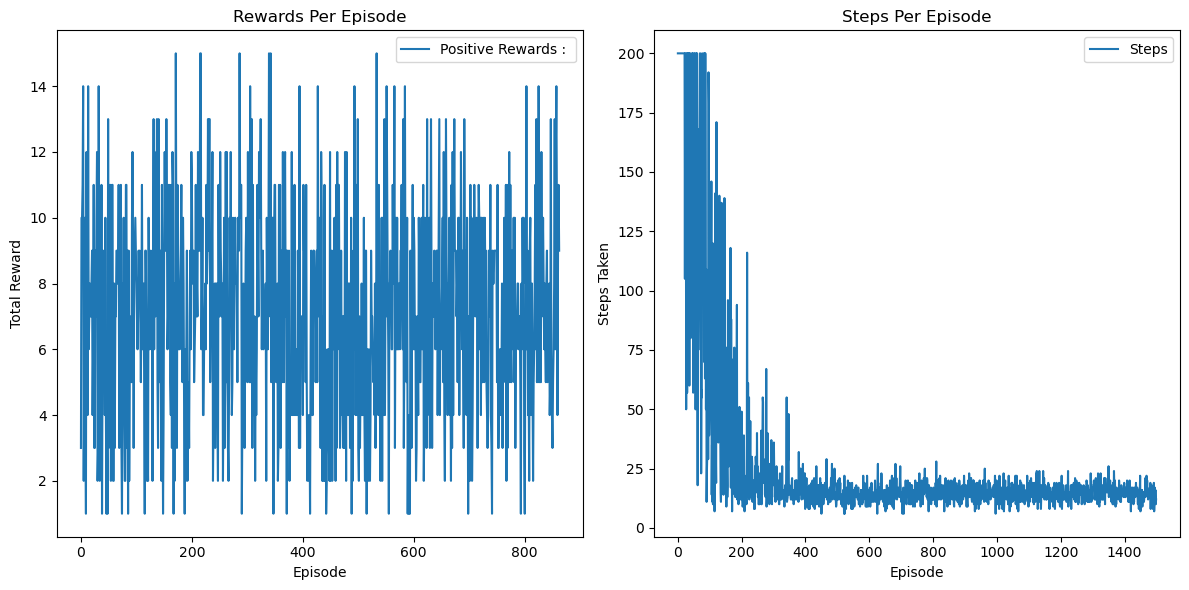

In [3]:
'''
NAME : ABHINAVA SAI BUGUDI
ID : W1947458
MODULE : 6ELEN018W - Applied Robotics
LECTURER NAME : Dr Dimitris C. Dracopoulos

'''

import gymnasium as gym
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt

# Defining the TaxiV3QLearningAgent using a class
class TaxiV3QLearningAgent:
    def __init__(self, env, num_train_episodes, alpha, gamma, epsilon, epsilon_min, epsilon_decay):
        self.env = env
        self.num_train_episodes = num_train_episodes
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.q_table = np.zeros([env.observation_space.n, env.action_space.n])
        self.all_rewards = []
        self.all_penalties = []
        self.all_steps = []

    def train(self):
        for episode in range(self.num_train_episodes):
            state = self.env.reset()[0]  # Initializing environment to start from scratch
            total_reward, penalties, steps = 0, 0, 0
            done = False

            while not done:
                # Exploration vs Exploitation
                if random.uniform(0, 1) < self.epsilon:
                    action = self.env.action_space.sample()  # Explore
                else:
                    action = np.argmax(self.q_table[state])  # Exploit

                # Taking an action
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated

                # updating the q table with new values
                old_value = self.q_table[state, action]
                next_max = np.max(self.q_table[next_state])
                self.q_table[state, action] = old_value + self.alpha * (reward + self.gamma * next_max - old_value)

                # Updating metrics for the graph
                state = next_state
                total_reward += reward
                if reward == -10:
                    penalties += 1
                steps += 1

            # Decaying epsilon for a controlled high exploration at the start and stay a bit more conservative at the end
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

            # Logging metrics
            self.all_rewards.append(total_reward)
            self.all_penalties.append(penalties)
            self.all_steps.append(steps)

        return self.q_table, self.all_rewards, self.all_penalties, self.all_steps

# Generating data from Q-table for 404 states
def generate_data_for_NN(q_table):
    data = []

    #encoding input data to give to the file
    for taxi_location in range(25): 
        for passenger_location in range(5): 
            for destination in range(4):
                if passenger_location == destination and passenger_location < 4:
                    continue  # Skipping states where passenger is already at the destination

                state_index = (taxi_location * 5 + passenger_location) * 4 + destination
                optimal_action = np.argmax(q_table[state_index])
                data.append((taxi_location, passenger_location, destination, optimal_action))

    # Adding 4 additional terminal states
    for destination in range(4):
        taxi_location = destination
        passenger_location = destination
        state_index = (taxi_location * 5 + passenger_location) * 4 + destination
        optimal_action = np.argmax(q_table[state_index])
        data.append((taxi_location, passenger_location, destination, optimal_action))

    columns = ["taxi_location", "passenger_location", "destination", "optimal_action"]
    return pd.DataFrame(data, columns=columns)

# Simulating a rnadom config to see how the model performs
def process_random_config(env, q_table):
    state = env.reset()[0]
    total_reward = 0
    steps = 0

    # Decoding the initial state to show the situation
    taxi_row, taxi_col, passenger_location, destination = env.unwrapped.decode(state)
    print("\n Starting simulation for a random configuration :")
    print(f"  Taxi Initial Location: (row={taxi_row}, col={taxi_col})")
    print(f"  Passenger Location: {passenger_location}")
    print(f"  Destination: {destination}")

    done = False
    while not done:
        action = np.argmax(q_table[state])
        next_state, reward, terminated, truncated, _ = env.step(action)
        print(f"Step {steps + 1}: Action={action}, Reward={reward}")
        total_reward += reward
        steps += 1
        state = next_state
        done = terminated or truncated

    print(f"\nSimulation complete. Total Reward: {total_reward}, Steps: {steps}")

# Plotting graphs for rewards and steps to change the epsilon, gamma and alpha values accordingly
def projecting_training_results(all_rewards, all_steps):
    positive_rewards = [reward for reward in all_rewards if reward > 0]
    plt.figure(figsize=(12, 6))

    # Plotting rewards
    plt.subplot(1, 2, 1)
    plt.plot(range(len(positive_rewards)), positive_rewards, label="Positive Rewards : ")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Rewards Per Episode")
    plt.legend()

    # Plotting steps
    plt.subplot(1, 2, 2)
    plt.plot(range(len(all_steps)), all_steps, label="Steps")
    plt.xlabel("Episode")
    plt.ylabel("Steps Taken")
    plt.title("Steps Per Episode")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Testing the model with extreme cases of configuration to measure how it does
def test_configuration(env, q_table, config, num_test_episodes=100):
    print(f"\nTesting configuration: {config}")
    total_rewards = []
    total_steps = []
    total_penalties = []

    for _ in range(num_test_episodes):
        env.reset(options={"taxi_row": config["taxi_row"], 
                           "taxi_col": config["taxi_col"], 
                           "passenger_index": config["passenger_index"], 
                           "destination_index": config["destination_index"]})
        state = env.reset()[0]
        total_reward, penalties, steps = 0, 0, 0
        done = False

        while not done:
            action = np.argmax(q_table[state])  
            next_state, reward, terminated, truncated, _ = env.step(action)
            state = next_state
            done = terminated or truncated
            total_reward += reward
            if reward == -10:
                penalties += 1
            steps += 1

        total_rewards.append(total_reward)
        total_steps.append(steps)
        total_penalties.append(penalties)

    print(f"  Average Reward: {np.mean(total_rewards):.2f}")
    print(f"  Average Steps: {np.mean(total_steps):.2f}")
    print(f"  Average Penalties: {np.mean(total_penalties):.2f}")

#MAIN
if __name__ == "__main__":
    env = gym.make("Taxi-v3", render_mode="rgb_array")

    # extreme configs
    extreme_configurations = [
        {"taxi_row": 0, "taxi_col": 0, "passenger_index": 3, "destination_index": 0},  # Taxi farthest from passenger
        {"taxi_row": 4, "taxi_col": 4, "passenger_index": 0, "destination_index": 3},  # Passenger farthest from destination
    ]

    #setting parameters
    num_train_episodes = 1500
    alpha = 0.9
    gamma = 0.8
    epsilon = 0.5
    epsilon_min = 0.1
    epsilon_decay = 0.985

    # Training agent
    print("!Training the Q-learning agent!")
    agent = TaxiV3QLearningAgent(env, num_train_episodes, alpha, gamma, epsilon, epsilon_min, epsilon_decay)
    q_table, train_rewards, train_penalties, train_steps = agent.train()

    # Generating and saving data for the next part
    print("!Generating data for neural network training!")
    Q_table_data = generate_data_for_NN(q_table)
    Q_table_data.to_csv("q_learning_data.csv", index=False)
    print("Data saved to 'q_learning_data.csv'.")

    # Analysing and testing the extreme configs
    for i, config in enumerate(extreme_configurations):
        print(f"\n Analyzing extreme configuration {i + 1}: {config}")
        test_configuration(env, q_table, config)

    # Simulating a random configuration and giving details
    process_random_config(env, q_table)

    # Plotting training results
    projecting_training_results(train_rewards, train_steps)

    env.close()
